In [1]:
import imblearn.datasets._zenodo as zenodo
print(zenodo.__doc__)

Collection of imbalanced datasets.

This collection of datasets has been proposed in [1]_. The
characteristics of the available datasets are presented in the table
below.

 ID    Name           Repository & Target           Ratio  #S       #F
 1     ecoli          UCI, target: imU              8.6:1  336      7
 2     optical_digits UCI, target: 8                9.1:1  5,620    64
 3     satimage       UCI, target: 4                9.3:1  6,435    36
 4     pen_digits     UCI, target: 5                9.4:1  10,992   16
 5     abalone        UCI, target: 7                9.7:1  4,177    10
 6     sick_euthyroid UCI, target: sick euthyroid   9.8:1  3,163    42
 7     spectrometer   UCI, target: >=44             11:1   531      93
 8     car_eval_34    UCI, target: good, v good     12:1   1,728    21
 9     isolet         UCI, target: A, B             12:1   7,797    617
 10    us_crime       UCI, target: >0.65            12:1   1,994    100
 11    yeast_ml8      LIBSVM, target: 8       

In [2]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

# datasets
from sklearn.model_selection import StratifiedKFold
from imblearn.datasets import fetch_datasets


# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
from imblearn.metrics import specificity_score, geometric_mean_score

# samplers
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE
from imblearn.combine import SPIDER

In [15]:
def pipeline(X, y, sampler=None):
    time_list = []
    size_list = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    specificity_list = []
    geometric_mean_list = []
    roc_auc_list = []
    
    logreg = LogisticRegression(solver='lbfgs', random_state=0, n_jobs=-1)
    
    skf = StratifiedKFold(n_splits=5, random_state=0)
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        
        t0 = time()
        if sampler:
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        else:
            X_resampled, y_resampled = X_train, y_train
        t1 = time()
        time_list.append(t1 - t0)
        size_list.append(len(y_resampled))

        logreg.fit(X_resampled, y_resampled)
        y_pred = logreg.predict(X_test)
        y_score = logreg.decision_function(X_test)

        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred))
        recall_list.append(recall_score(y_test, y_pred))
        specificity_list.append(specificity_score(y_test, y_pred))
        geometric_mean_list.append(geometric_mean_score(y_test, y_pred))
        roc_auc_list.append(roc_auc_score(y_test, y_score))

    return dict(
        accuracy=np.mean(accuracy_list),
        precision=np.mean(precision_list),
        recall=np.mean(recall_list),
        specificity=np.mean(specificity_list),
        geometric_mean=np.mean(geometric_mean_list),
        roc_auc=np.mean(roc_auc_list),
        size=np.mean(size_list),
        time=np.mean(time_list),
    )


def benchmark(id):
    name = list(fetch_datasets())[id-1]
    dataset = fetch_datasets()[name]
    
    X, y = dataset.data, dataset.target

    ncr = NeighbourhoodCleaningRule(random_state=0, n_jobs=-1)
    smote = SMOTE(random_state=0, n_jobs=-1)
    weak = SPIDER(kind='weak', n_jobs=-1)
    relabel = SPIDER(kind='relabel', n_jobs=-1)
    strong = SPIDER(kind='strong', n_jobs=-1)

    results_none = pipeline(X, y)
    results_smote = pipeline(X, y, smote)
    results_ncr = pipeline(X, y, ncr)
    results_weak = pipeline(X, y, weak)
    results_relabel = pipeline(X, y, relabel)
    results_strong = pipeline(X, y, strong)

    results_list =  [results_none, results_smote, results_ncr, results_weak, results_relabel, results_strong]

    accuracies =    [r['accuracy'] for r in results_list]
    precisions =    [r['precision'] for r in results_list]
    recalls =       [r['recall'] for r in results_list]
    specificities = [r['specificity'] for r in results_list]
    geometric_means=[r['geometric_mean'] for r in results_list]
    roc_aucs =      [r['roc_auc'] for r in results_list]
    sizes =         [r['size'] for r in results_list]
    times =         [r['time'] for r in results_list]

    results_dict = dict(
        accuracy=accuracies,
        precision=precisions,
        recall=recalls,
        specificity=specificities,
        geometric_mean=geometric_means,
        roc_auc=roc_aucs,
        size=sizes,
        time=times,
    )

    index = pd.Index(['none', 'smote', 'ncr','weak', 'relabel', 'strong'], name=name)
    results_df = pd.DataFrame(results_dict, index=index)

    results_df.to_pickle(f'../benchmark_{name}.pkl')
    return results_df

In [16]:
for id in np.arange(10) + 1:
    benchmark(id)

/Users/matteding/miniconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matteding/miniconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matteding/miniconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matteding/miniconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predict

            accuracy  precision    recall  specificity
car_eval_4                                            
none        0.979769   0.800000  0.615385     0.993994
smote       0.965318   0.520000  1.000000     0.963964
ncr         0.979769   0.800000  0.615385     0.993994
weak        0.979769   0.666667  0.923077     0.981982
relabel     0.979769   0.666667  0.923077     0.981982
strong      0.973988   0.590909  1.000000     0.972973


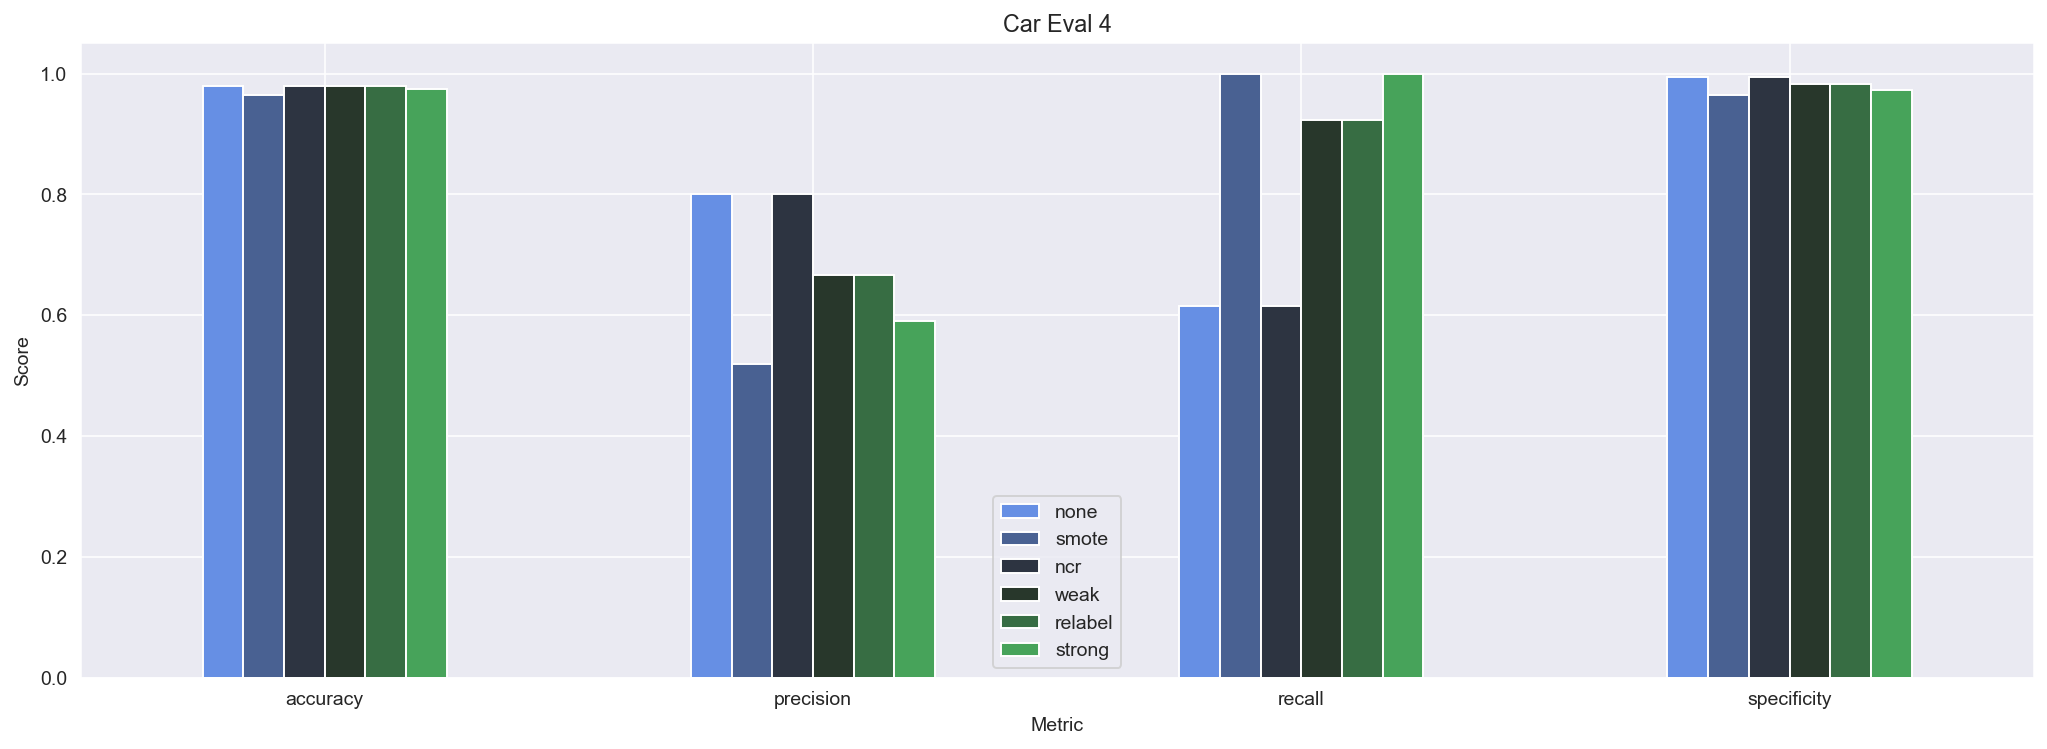

In [122]:
df = pd.read_pickle('../benchmark_car_eval_4.pkl')

# todo: output CSV
methods = ['none', 'smote', 'ncr', 'weak', 'relabel', 'strong']
metrics = ['accuracy', 'precision', 'recall', 'specificity', 'geometric_mean']
print(df.loc[methods, metrics])

def plot_benchmark(df, save=True):
    palette = sns.diverging_palette(255, 133, l=60, n=6, center="dark")
    # palette = 'inferno'
    sns.set_style('darkgrid')
    sns.set_palette(palette)
    title = " ".join(df.index.name.split("_")).title()
    name = df.index.name
    df.index.name = None
    fig = plt.figure(dpi=140)
    df.loc[methods, metrics].T.plot.bar(figsize=(18, 6), title=title, rot=0, ax=plt.gca())
    plt.xlabel('Metric')
    plt.ylabel('Score')
    if save:
        plt.savefig(f'../benchmark_{name}.png', bbox_inches='tight')

In [7]:
ls ../benchmark*

ls: ../benchmark*: No such file or directory
